Importar librerías: 
* os: para la unión de varios archivos en un solo dataframe
* pandas: para la creación y manipulación de dataframes
* GeoPandas: para la generación y visualización de los mapas interactivos
* libpysAL:para análisis geoespacial mediante clustering, servirá de apoyo en la generación de una matriz de pesos y adyacencias
* spopt (parte de PySAL): para métodos de ML no supervisado de regionalización (clustering con restricción de proximidad espacial)
* seaborn: para la representación mediante gráficas de los dataframes, en este caso en concreto se usará para la representación de un heatmap (mapa de calor)
* sklearn: es una librería muy usada para modelos de machine learning, en este caso la usaremos para normalizar los datos mediante StandardScaler.

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import geopandas as gpd
import libpysal
import spopt

import seaborn as sns
from sklearn.preprocessing import StandardScaler

Concatenar ficheros de datos de potencia (W) de energía eléctrica de cada provincia en un solo dataframe, generada a partir de fuentes de energía renovables, cogeneración y residuos. Los tipos de fuentes de energía están etiquetados según: https://www.boe.es/buscar/act.php?id=BOE-A-2014-6123. En el siguiente paso trataremos de limpiar el dataset con la información relevante

In [11]:
# https://energia.serviciosmin.gob.es/Pretor/Vista/Informes/InformesInstalaciones.aspx
basepath = 'Data/energia'
d_energia_raw = pd.DataFrame()
for entry in os.listdir(basepath):
    file = os.path.join(basepath, entry)
    if os.path.isfile(file):
        file_pd = pd.read_html(file)[0]
        d_energia_raw = pd.concat([d_energia_raw, file_pd], axis=0)

Limpieza de datos y agregación para obtener totales de potencia (W) por municipio, cada código viene representado por 1 tipo de generación de energía renovable, aqui se deja una breve descripción de lo que significa cada código, para más información, puede visitarse https://www.boe.es/buscar/act.php?id=BOE-A-2014-6123:

* a.1-Cogeneración mediante gas natural, petróleo, etc\
* b.1-Energía solar\
* b.2-Energía eólica\
* b.3-Geotérmica, hidrotérmica, aerotérmica, la de las olas, la de las mareas, la de las rocas calientes y secas, la oceanotérmica y la energía de las corrientes marinas\
* b.4-Hidroeléctricas <10MW\
* b.5-Hidroeléctricas >10MW\
* b.6-Biomasa procedente de cultivos energéticos, de actividades agrícolas, ganaderas o de jardinerías\
* b.7-Biogas o bioliquidos\
* b.8-biomasa sector agrícola\
* c.1-Residuos domésticos y similares

In [12]:
d_energia = d_energia_raw.iloc[1:, [2,6,7]] 
d_energia.columns = ["Municipio", "Potencia", "Tipo"]
d_energia = d_energia[d_energia.Tipo != "Almacenamiento"]
d_energia["Tipo"] = d_energia["Tipo"].str[0:3]
d_energia["Potencia"] = pd.to_numeric(
                            d_energia["Potencia"].str.replace('.', '').str.replace(',', '.'), 
                        errors="coerce")
d_energia = d_energia \
                .dropna() \
                .sort_values(by='Municipio') \
                .groupby(["Municipio", "Tipo"], as_index=False) \
                .agg({"Potencia": "sum"}) \
                .pivot(index="Municipio", columns='Tipo', values='Potencia') \
                .fillna(0)
d_energia.head()

Tipo,a.1,a.2,b.1,b.2,b.3,b.4,b.5,b.6,b.7,b.8,c.1,c.2,c.3,c.4,d.1,d.2
Municipio,,,,,,,,,,,,,,,,
Abadiño,0.0,0.0,95000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abadía,0.0,0.0,1155000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abadín,0.0,0.0,42600.0,263510000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abaltzisketa,0.0,0.0,7500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abanilla,0.0,0.0,12612000.0,91440000.0,0.0,0.0,0.0,0.0,1064000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para generar los mapas interactivos de península, canarias y baleares se ha planteado representar cada uno de los municipios mediante polígonos, en el código situado inmediatamente abajo se ha importado dicha información de cada municipio, conservando nombre (NAMEUNIT) y una lista de los vértices mediante coordendas de cada polígono (geometry)

In [13]:
# http://centrodedescargas.cnig.es/CentroDescargas/index.jsp
gd = pd.concat([
    gpd.read_file("Data/poly_peninbal/poly_peninbal.shp").to_crs("epsg:4326"),
    gpd.read_file("Data/poly_canarias/poly_canarias.shp").to_crs("epsg:4326")
])
gd = gd[["NAMEUNIT", "geometry"]] \
        .rename(columns={"NAMEUNIT": "Municipio"}) \
        .sort_values(by='Municipio') \
        .drop_duplicates(subset="Municipio", keep='first') \
        .set_index("Municipio")
gd.head()

,geometry
Municipio,
A Arnoia,"POLYGON ((-8.15983 42.24513, -8.15928 42.24542..."
A Baña,"POLYGON ((-8.83259 42.96346, -8.83205 42.96402..."
A Bola,"POLYGON ((-7.93304 42.11927, -7.93296 42.11967..."
A Capela,"POLYGON ((-8.10065 43.46198, -8.10019 43.46213..."
A Cañiza,"POLYGON ((-8.39289 42.16872, -8.39335 42.16931..."


Se genera un dataset con la unión de datos de potencia generada por tipo y municipio junto con los datos geográficos de dichos municipios

In [14]:
d = gd.join(d_energia, how="left").fillna(0)

A modo de ejemplo vamos a visualizar el mapa coroplético (mapa coloreado por regiones) de la distribución de la potencia generada por fuentes de energía de tipo "b.1", correspondiente a: 
* Grupo b.1 Instalaciones que utilicen como energía primaria la energía solar.

Para una representación eficiente del mapa interactivo se va a usar el agoritmo de Douglas-Peucker, mediante este algoritmo se reduce el número de vértices de cada polígono, suavizando de esta manera el polígono y por contra reduciendo el nivel de detalle del mapa en favor de una mayor rapidez de ejecución

In [15]:
# Douglas-Peucker Algorithm to simplify geometries
d_plot = gpd.GeoDataFrame(d)
d_plot.geometry = d_plot.geometry.simplify(0.005)
d_plot.explore(column="b.1", 
               cmap="BuPu",
               scheme='HeadTailBreaks',
               tooltip=False,
               popup=True,
               style_kwds={"weight": 0.4}).save('Data/Mapas/mapa_b1.html')

Como segundo ejemplo, visualicemos el mapa coroplético de la distribución de la potencia generada por fuentes de energía de tipo "b.2", correspondiente a: 
* Grupo b.2 Instalaciones que únicamente utilicen como energía primaria la energía eólica

De nuevo usando el algoritmo de Douglas-Peucker

In [16]:
# Douglas-Peucker Algorithm to simplify geometries
d_plot = gpd.GeoDataFrame(d)
d_plot.geometry = d_plot.geometry.simplify(0.005)
d_plot.explore(column="b.2", 
               cmap="BuPu",
               scheme='HeadTailBreaks',
               tooltip=False,
               popup=True,
               style_kwds={"weight": 0.4}).save("Data/Mapas/mapa_b2.html")

Para poder realizar el clustering (agrupación en conjuntos) de los municipios con características similares (en lo que a generación de energías renovables respecta) necesitaremos una restricción espacial, es decir, agruparemos por conjuntos con características similares, siempre y cuando dichos municipios compartan fronteras, en otras palabras, siempre y cuando sean contiguos entre sí.

Para dicha restricción espacial, usaremos la matriz 'w', la cual indica la adyacencia entre los distintos municipios que comparten frontera (Rook neighbours)

In [17]:
# Rook neighbors are those states that share an edge on their respective borders
# Queen neighbors are based on a more inclusive condition that requires only a shared vertex between two states
w = libpysal.weights.Rook.from_dataframe(d)

A continuación, procedemos a agrupar por conjuntos (clusters) los diferentes municipios. Para ello usaremos el algoritmo 'max-P regions' que nos generará la división de conjuntos teniendo en cuenta la matriz de adyacencia 'w' generada en el paso anterior, así como un threshold (umbral inferior) minimo de municipios por cluster.

En resumen, generamos clusters con municipios con generación de energía eléctrica de fuentes renovables similares entre sí, que, a su vez, compartan frontera, con un mínimo de 80 municipios por cluster.

El clustering es un algoritmo de aprendizaje automático (machine learning) muy usado para el aprendizaje no supervisado cuando tenemos un conjunto de datos sin etiquetar y del cual queramos sacar conclusiones

In [18]:
# Max-P Heuristic with a minimum number of towns per cluster
d["Count"] = 1
attrs_name = list(d.columns)[1:-1]
# https://pysal.org/spopt/generated/spopt.region.MaxPHeuristic.html#spopt.region.MaxPHeuristic
model = spopt.region.MaxPHeuristic(d, w, attrs_name, 
                                   verbose=True,
                                   # At least 80 towns per cluster
                                   threshold=80, 
                                   threshold_name="Count", 
                                   # Computational cost
                                   max_iterations_sa=10,
                                   max_iterations_construction=999,
                                   top_n=10,
                                   # Attach infeasible components using a single linkage between the area in the infeasible component with the smallest nearest neighbor distance to an area in a feasible component
                                   policy="single")
model.solve()
d['Cluster'] = model.labels_
# Store df in an csv file
d.to_csv("Data/Output/output.csv", index=True)

max_p:  91
number of good partitions: 1
0
totalWithinRegionDistance after SA: 
5808014553485.0
totalWithinRegionDistance after SA: 
5809967335088.0
totalWithinRegionDistance after SA: 
5788138463466.0
totalWithinRegionDistance after SA: 
5801963808356.0
totalWithinRegionDistance after SA: 
5785676345476.0
totalWithinRegionDistance after SA: 
5807692399652.0
totalWithinRegionDistance after SA: 
5771797934413.0
totalWithinRegionDistance after SA: 
5807109012982.0
totalWithinRegionDistance after SA: 
5775221838254.0
totalWithinRegionDistance after SA: 
5833148416385.0
best objective value:
5771797934413.0


Repetimos la representación mediante el mapa coroplético, esta vez mediante los clusters generados y no mediante las fuentes renovables para la generación de energía eléctrica como hicimos con anterioridad

In [19]:
# Douglas-Peucker Algorithm to simplify geometries
d_plot = gpd.GeoDataFrame(d)
d_plot.geometry = d_plot.geometry.simplify(0.005)
d_plot.explore(column="Cluster", 
           cmap="Set1",
           tooltip=False,
           popup=True,
           legend=True,
           style_kwds={"weight": 0.4}).save("Data/Mapas/mapa_clusters_1.html")

Mapa de calor que muestra los valores medios de cada variable (potencia de la fuente de producción de energía) en los municipios de cada cluster generado. Valores superiores a 0 están por encima de la media.

<Axes: ylabel='Cluster'>

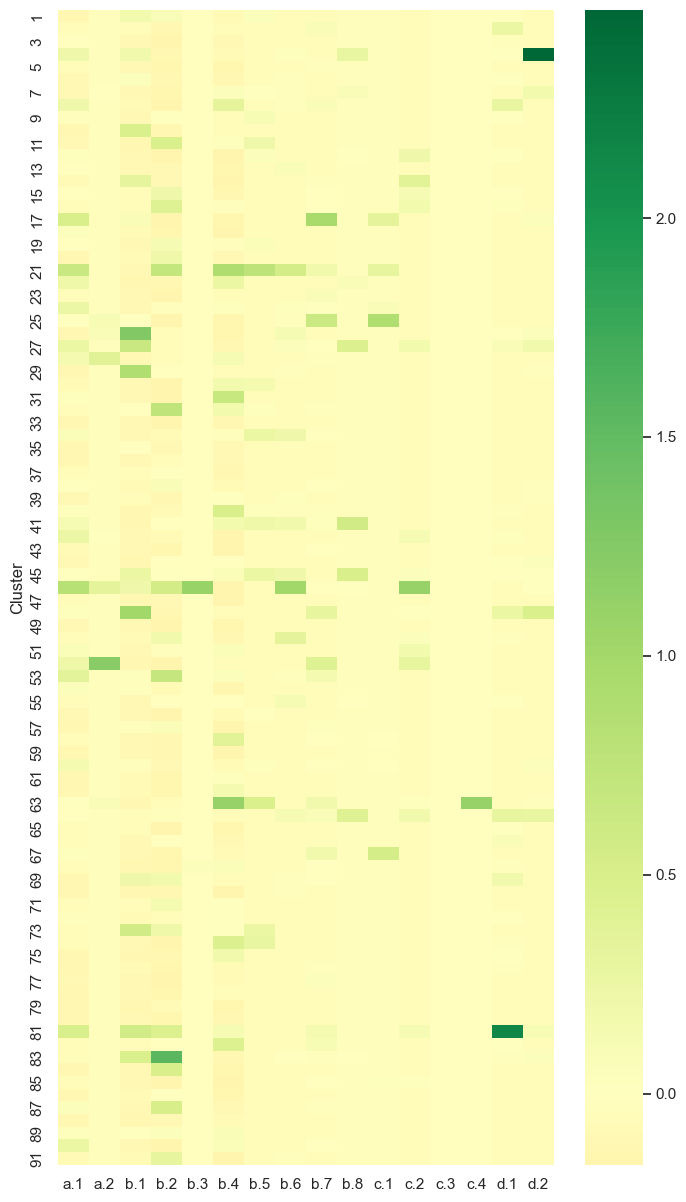

In [20]:
aux = d.drop(columns=["geometry","Count","Cluster"])
d_scaled = pd.DataFrame(
    StandardScaler().fit_transform(aux),
    columns = aux.columns,
    index = aux.index
)
d_scaled["Cluster"] = d.Cluster
sns.set(rc={'figure.figsize':(8,15)})
sns.heatmap(d_scaled.groupby("Cluster").mean(), cmap="RdYlGn", center=0)

Anteriormente, para establecer el tamaño de cada agrupación (cluster) poníamos como threshold (umbral) el número de municipios. 
En este caso, vamos a realizar las agrupaciones estableción un mímo en función del número total de habitantes, y no del mínimo total de municipios.
Para ello necesitaremos el número total de habitantes por municipio, el cual importaremos y uniremos al dataframe original


In [21]:
# https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/30832.csv
# d_poblacion = pd.read_csv("https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/30832.csv", sep=";", decimal=",")
# d_poblacion.to_parquet("poblacion.parquet")
d_poblacion = pd.read_parquet("Data/poblacion/poblacion.parquet")
d_poblacion["Municipios"] = d_poblacion["Municipios"].str[6:]
d_poblacion["Total"] = pd.to_numeric(
    d_poblacion["Total"].str.replace('.', '').str.replace(',', '.'), 
    errors="coerce")
d_poblacion = d_poblacion[(d_poblacion.Periodo == 2020) &
                          (d_poblacion["Indicadores demográficos"] == "Población") &
                          (d_poblacion.Distritos.isna()) &
                          (d_poblacion.Secciones.isna())] \
            .drop(["Distritos", "Secciones", "Indicadores demográficos", "Periodo"], axis=1) \
            .dropna() \
            .rename(columns={"Total": "Poblacion",
                             "Municipios": "Municipio"}) \
            .set_index("Municipio")
d_poblacion.head()
d_energia = d_energia.join(d_poblacion, how="inner")
d = gd.join(d_energia, how="left").fillna(0)

Creación de la matriz de adyacencias 'w' que será usada para el algoritmo de clustering con el nuevo threshold

In [22]:
# Rook neighbors are those states that share an edge on their respective borders
# Queen neighbors are based on a more inclusive condition that requires only a shared vertex between two states
w = libpysal.weights.Rook.from_dataframe(d.drop(columns=["Poblacion"]))

Volvemos a ejecutar el mismo clustering mediante el algoritmo de max-P regions, pero modificando el umbral (threshold & threshold_name)

In [23]:
# Max-P Heuristic with a minimum number population per cluster
attrs_name = list(d.columns)[1:-1]
# https://pysal.org/spopt/generated/spopt.region.MaxPHeuristic.html#spopt.region.MaxPHeuristic
model = spopt.region.MaxPHeuristic(d, w, attrs_name, 
                                   verbose=True,
                                   # At least 200,000 people per cluster
                                   threshold=200000, 
                                   threshold_name="Poblacion", 
                                   # Computational cost
                                   max_iterations_sa=10,
                                   max_iterations_construction=999,
                                   top_n=10,
                                   # Attach infeasible components using a single linkage between the area in the infeasible component with the smallest nearest neighbor distance to an area in a feasible component
                                   policy="single")
model.solve()
d['Cluster'] = model.labels_
# Store df in an csv file
d.to_csv("Data/Output/output2.csv", index=True)

max_p:  123
number of good partitions: 1
0


c:\Users\ignac\OneDrive\Documents\Hackaton 2023\PythonVoilaDemo\.venv\lib\site-packages\spopt\region\maxp.py:672: RuntimeWarning: overflow encountered in double_scalars
  prob = np.exp(diff / t)


totalWithinRegionDistance after SA: 
5560046681953.0
totalWithinRegionDistance after SA: 
5119416293089.0
totalWithinRegionDistance after SA: 
5219147546940.0
totalWithinRegionDistance after SA: 
5193505158963.0
totalWithinRegionDistance after SA: 
5214892322352.0
totalWithinRegionDistance after SA: 
5218599466982.0
totalWithinRegionDistance after SA: 
5186081063303.0
totalWithinRegionDistance after SA: 
5617176358188.0
totalWithinRegionDistance after SA: 
5225923946995.0
totalWithinRegionDistance after SA: 
5057759361286.0
best objective value:
5057759361286.0


Representamos de nuevo el mapa coroplético con los nuevos clusters creados en función del threshold de población

In [24]:
# Douglas-Peucker Algorithm to simplify geometries
d_plot = gpd.GeoDataFrame(d)
d_plot.geometry = d_plot.geometry.simplify(0.005)
d_plot.explore(column="Cluster", 
           cmap="Set1",
           tooltip=False,
           popup=True,
           legend=True,
           style_kwds={"weight": 0.4}).save("Data/Mapas/mapa_clusters_2.html")

Mapa de calor con los valores medios de los nuevos clusters

<Axes: ylabel='Cluster'>

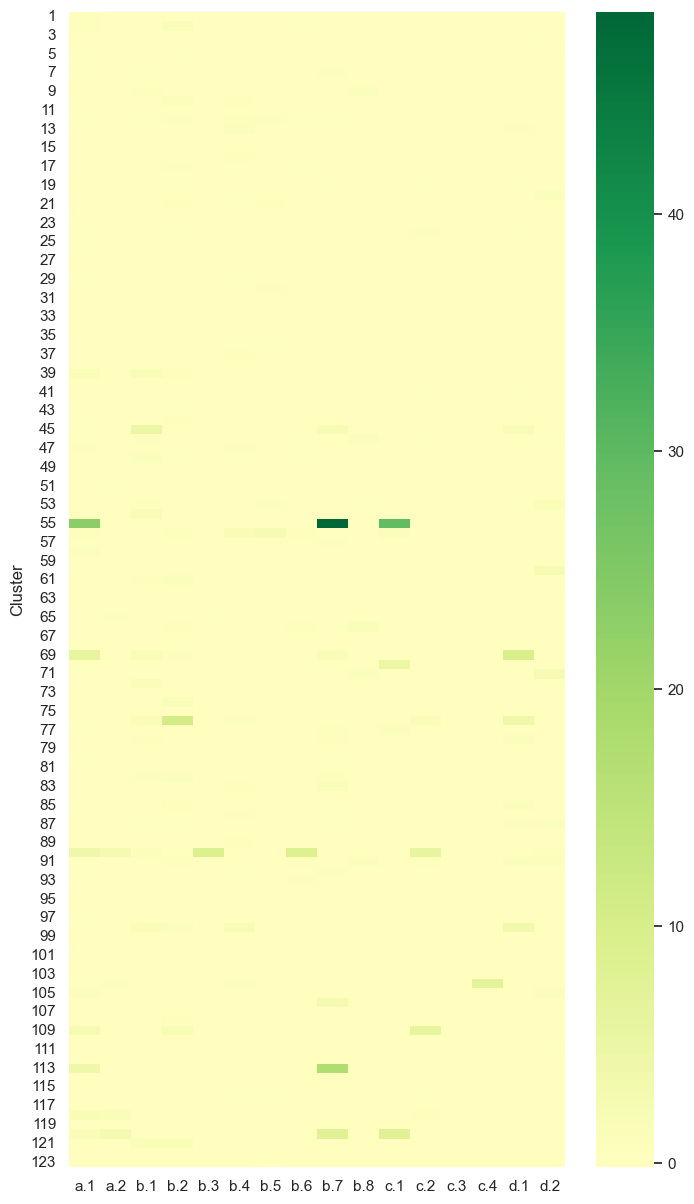

In [25]:
aux = d.drop(columns=["geometry","Poblacion","Cluster"])
d_scaled = pd.DataFrame(
    StandardScaler().fit_transform(aux),
    columns = aux.columns,
    index = aux.index
)
d_scaled["Cluster"] = d.Cluster
sns.set(rc={'figure.figsize':(8,15)})
sns.heatmap(d_scaled.groupby("Cluster").mean(), cmap="RdYlGn", center=0)